In [1]:
import cv2
import glob
import random
import csv as csv
import numpy as np
import pandas as pd
import scipy.spatial.distance
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pylab import *
from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage import data, color, exposure
from skimage.color import label2rgb
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

%matplotlib inline

/Users/michellechen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Draw pictures by result ranking

def plot_results(res):
    """ Show images in result list 'res'. """
    figure()
    nbr_results = len(res)
    for i in range(nbr_results):
        subplot(1,nbr_results,i+1)
        imshow(array(Image.open(res[i])))
        axis('off')
    show()

In [ ]:
# Image Patch Extraction: Divide one image into 9 (3X3) blocks

# def patch(image, width, height):
    

In [3]:
# Get image's LBP 

def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
        
def hist(ax, lbp):
    n_bins = lbp.max() + 1
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

def GET_LBP(im_path):
    radius = 3
    n_points = 8 * radius
    METHOD = 'uniform'
    image = cv2.imread(im_path, 0)
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    lbp = lbp.reshape(600*600) # Reshape to one dimension
#     lbp = lbp.reshape(218*255) 
    return lbp

In [4]:
# Get image's HOG

def GET_HOG(im_path):
    image = cv2.imread(im_path, 0)
    image = color.rgb2gray(image)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(1, 1), visualise=True)
    hog_image = hog_image.reshape(600*600) # Reshape to one dimension
    return hog_image

In [5]:
# Get image's Color Histogram

def GET_COLOR(im_path):
    image = cv2.imread(im_path)
    # Calculate query image's color histogram by cv2 and show it
    #hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist).flatten()
    return hist

In [6]:
# Get all image path

im_path = glob.glob("outfit_images/20170821/*.jpg")

In [7]:
# Get all clothing images' LBP and HOG features and combine them to an one dimension feature

im_COLOR = []
im_LBP = []
im_HOG = []
im_feature = []

for i in xrange(len(im_path)):
    
    im_COLOR.append(GET_COLOR(im_path[i]))
    #print "image" + str(i+1) + "'s Color Histogram:"
    #print im_COLOR[i]
    
    im_LBP.append(GET_LBP(im_path[i]))
    #print "image" + str(i+1) + "'s LBP:"
    #print im_LBP[i]

    im_HOG.append(GET_HOG(im_path[i]))
    #print "image" + str(i+1) + "'s HOG:"
    #print im_HOG[i]
    
    # Comebine Color Histogram, LBP, HOG to an one dimensional feature
    im_feature.append(np.append(np.append(im_COLOR[i], im_LBP[i]), im_HOG[i]))
    #im_feature.append(np.append(im_COLOR[i], (im_LBP[i] + im_HOG[i])))
    print "image" + str(i+1) + "'s feature:"
    print im_feature[i]
    
    # Draw out the clothing image
#     figure()
#     imshow(array(Image.open(im_path[i])))
#     axis('off')
#     plt.show()

image1's feature:
[ 0.24237016  0.0169488   0.01725638 ...,  0.          0.          0.        ]
image2's feature:
[ 0.27133054  0.06552646  0.00074421 ...,  0.          0.          0.        ]
image3's feature:
[ 0.002059    0.00023225  0.00012059 ...,  0.          0.          0.        ]
image4's feature:
[  1.96521536e-01   1.71673438e-03   1.70053871e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
image5's feature:
[ 0.00994868  0.00221929  0.00113345 ...,  0.          0.          0.        ]
image6's feature:
[ 0.01422924  0.00781654  0.00387458 ...,  0.          0.          0.        ]
image7's feature:
[ 0.00137832  0.00094144  0.0001969  ...,  0.          0.          0.        ]
image8's feature:
[ 0.12919463  0.00824672  0.00026759 ...,  0.          0.          0.        ]
image9's feature:
[ 0.03192133  0.00988029  0.         ...,  0.          0.          0.        ]
image10's feature:
[  1.08930934e-02   2.56367202e-04   3.01608488e-05 ...,   0.00000000e+00
   

In [7]:
# Positive pair data

pair_df = pd.read_csv('PAIR.csv')

print pair_df

      pairA  pairB
0         1    158
1         1    502
2         2    158
3         2    502
4         3    624
5         3    123
6         3    166
7         4    123
8         4    624
9         4    166
10        5    166
11        5    624
12        5    123
13        6    119
14        6    717
15        7    119
16        7    717
17        8    118
18        8     37
19        8    232
20        8    578
21        9      4
22       10      4
23       25    145
24       26    145
25       27    620
26       29    125
27       29    125
28       29    717
29       29     96
...     ...    ...
1892    921    578
1893    921    919
1894    922    886
1895    922    918
1896    922    941
1897    923    941
1898    923    886
1899    923    918
1900    924    923
1901    924    922
1902    927    169
1903    928    644
1904    930    689
1905    930    697
1906    931    918
1907    931    113
1908    932     97
1909    932    118
1910    932     88
1911    932     97
1912    933 

In [8]:
pair_df.values[0][0], pair_df.values[0][1]

(1, 158)

In [9]:
# Using random sample to generate negative pair data

import random

item = []
for i in xrange(942):
    item.append(i+1)

notpair = []
for i in xrange(1922):
    notpair.append(random.sample(item, 2))
    print notpair[i]

[101, 806]
[98, 607]
[327, 15]
[684, 719]
[429, 278]
[60, 599]
[387, 357]
[514, 19]
[618, 817]
[276, 814]
[424, 442]
[345, 733]
[534, 670]
[842, 6]
[542, 581]
[61, 316]
[413, 105]
[340, 873]
[503, 623]
[755, 27]
[861, 484]
[393, 642]
[862, 86]
[538, 25]
[64, 295]
[428, 851]
[853, 228]
[463, 10]
[473, 608]
[400, 5]
[599, 534]
[758, 278]
[415, 774]
[740, 405]
[228, 483]
[474, 832]
[900, 819]
[516, 752]
[621, 365]
[268, 456]
[428, 293]
[912, 294]
[247, 572]
[750, 533]
[849, 120]
[213, 925]
[884, 912]
[395, 133]
[299, 471]
[551, 550]
[380, 145]
[938, 102]
[863, 55]
[904, 13]
[610, 586]
[154, 47]
[87, 925]
[678, 901]
[237, 342]
[534, 51]
[444, 791]
[162, 453]
[748, 592]
[697, 654]
[90, 827]
[795, 808]
[833, 140]
[473, 333]
[753, 250]
[169, 833]
[934, 467]
[407, 621]
[581, 675]
[530, 865]
[777, 380]
[44, 594]
[406, 612]
[831, 269]
[442, 605]
[33, 16]
[322, 175]
[789, 917]
[337, 431]
[125, 756]
[318, 194]
[531, 103]
[863, 336]
[905, 465]
[53, 803]
[182, 663]
[614, 217]
[560, 942]
[569, 273]
[

In [10]:
# Combine the feature of pair images

pair_feature = []
notpair_feature = []

for i in xrange(1922):
    pairA = pair_df.values[i][0]
    pairB = pair_df.values[i][1]
    pairC = notpair[i][0]
    pairD = notpair[i][1]
    pair_feature.append(np.append(im_feature[pairA-1], im_feature[pairB-1]))
    notpair_feature.append(np.append(im_feature[pairC-1], im_feature[pairD-1]))
    
    print "pair" + str(i+1) + "'s feature:"
    print pair_feature[i]
    print "notpair" + str(i+1) + "'s feature:"
    print notpair_feature[i]

pair1's feature:
[  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
notpair1's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair2's feature:
[  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
notpair2's feature:
[ 0.25584623  0.18037222  0.         ...,  0.          0.          0.        ]
pair3's feature:
[ 0.00010238  0.          0.         ...,  0.          0.          0.        ]
notpair3's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair4's feature:
[ 0.00010238  0.          0.         ...,  0.          0.          0.        ]
notpair4's feature:
[ 0.13118269  0.00041368  0.         ...,  0.          0.          0.        ]
pair5's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
notpair5's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair6's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
notpair6's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair7's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
notpair7

In [11]:
print len(im_COLOR[0])
print len(im_LBP[0])
print len(im_HOG[0])
print len(im_feature[0])
print len(pair_feature[0])

# All the positive pair and negative pair, store with their feature
allpair_feature = pair_feature + notpair_feature 

print len(allpair_feature), len(allpair_feature[0])

512
55590
55590
111692
223384
3844 223384


In [ ]:
# Using PCA to decompose the feature of all pair to 10000 dimension
pca1 = PCA(n_components=1000)
allpair_feature_pca1 = pca1.fit_transform(allpair_feature)

In [ ]:
# Using PCA to decompose the feature of all pair to 500 dimension
pca2 = PCA(n_components=500)
allpair_feature_pca2 = pca2.fit_transform(allpair_feature)

In [ ]:
# Using PCA to decompose the feature of all pair to 100 dimension
pca3 = PCA(n_components=100)
allpair_feature_pca3 = pca3.fit_transform(allpair_feature)

In [16]:
# Training data (500 of positive and 500 of negative)
X = pair_feature[0:500] + notpair_feature[0:500]
X = np.array(X)

In [17]:
# Truth of training data
Y = []
for i in xrange(500):
    Y.append(1)
for i in xrange(500):
    Y.append(0)
Y = np.array(Y)

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.svm import SVC
estimator = SVC(kernel='linear')

In [20]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [ ]:
from sklearn.grid_search import GridSearchCV
import numpy as np
gammas = np.logspace(-6, -1, 10)
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(gamma=gammas))
classifier.fit(X_train, y_train)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
from sklearn.learning_curve import learning_curve
title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
estimator = SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
plt.show()

In [ ]:
# SVM Model
svc1 = svm.SVC(kernel='rbf', C=1, gamma=0).fit(X, Y)

print roc_auc_score(Y, svc1.predict(X))

In [15]:
# Testing data
test = pair_feature[1000:1500] + notpair_feature[1000:1500]
test = np.array(test)

# Truth of testing data
test_truth = []
for i in xrange(500):
    test_truth.append(1)
for i in xrange(500):
    test_truth.append(0)
test_truth = np.array(test_truth)

0.5


In [ ]:
print roc_auc_score(test_truth, svc1.predict(test))

In [16]:
# Random Forest Regression Model
# n_estimators
n_estimators_options = [10, 30, 50, 100, 200]

for trees in n_estimators_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1)
    model = model.fit(X, Y)
    print trees   
    print roc_auc_score(Y, model.oob_prediction_)

/Users/michellechen/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:600: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10
0.879228
30
0.940242
50
0.952926
100
0.955058
200
0.957524


In [17]:
print roc_auc_score(test_truth, model.predict(test))

0.56015


In [53]:
# SVR Model
svr = SVR(C=1.0, epsilon=0.2).fit(X, Y)

print roc_auc_score(Y, svr.predict(X))

1.0


In [54]:
# Combine positive and negative pair to one dataset

train = pair_feature + notpair_feature
train = np.array(train)
print train

# Generate ground truth data (positive is 1, negative is 0)

truth = []

for i in xrange(len(pair_feature)):
    truth.append(1)
for i in xrange(len(notpair_feature)):
    truth.append(0)

truth = np.array(truth)
print truth

[[  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.02380523e-04   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.05716696e-03   5.68227237e-03   1.10672163e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.15788018e-03   0.00000000e+00   2.03136879e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[1 1 1 ..., 0 0 0]


In [ ]:
svr = SVR(C=1.0, epsilon=0.2).fit(train, truth)

print roc_auc_score(truth, svr.predict(train))

In [14]:
# Random forest for train data

# n_estimators
n_estimators_options = [100]

for trees in n_estimators_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1)
    model = model.fit(train, truth)
    print trees   
    print roc_auc_score(truth, model.oob_prediction_)
    

100
0.857513527034


In [ ]:
# min_samples_leaf

min_samples_leaf_options = [50, 100, 200]

for min_samples_leaf in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, min_samples_leaf=min_samples_leaf)
    model = model.fit(train, truth)
    print min_samples_leaf   
    print roc_auc_score(truth, model.oob_prediction_)
    

In [30]:
# One-class SVM for only positive data

train = pair_feature[0:1922/2]
test = pair_feature[961:1922]

model = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
model.fit(train)
pred_train = model.predict(train)
pred_test = model.predict(test)
error_train = pred_train[pred_train == -1].size
error_test = pred_test[pred_test == -1].size


In [38]:
pred_train

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

TypeError: list indices must be integers, not tuple

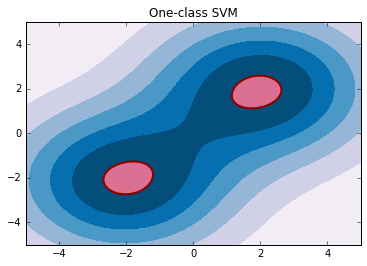

In [40]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

# # plot the line, the points, and the nearest vectors to the plane
# Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

plt.title("One-class SVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(train[:, 0], train[:, 1], c='white', s=s)
b2 = plt.scatter(test[:, 0], test[:, 1], c='blueviolet', s=s)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2],
           ["learned frontier", "training observations",
            "new regular observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/961 ; errors novel regular: %d/961 ; "
    % (error_train, error_test))
plt.show()

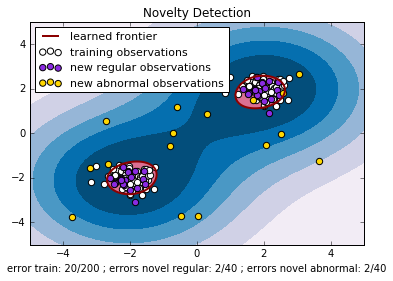

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

Drag your image here: outfit_images/20170821/20170821-226942335.jpg
Your query clothing:


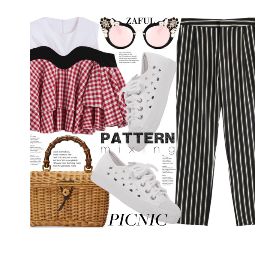

In [8]:
# Get the image by user input as a query clothing

# Get input image path
query_path = raw_input("Drag your image here: ")

# Read image
query_im = cv2.imread(query_path, 0)

# Show image
print "Your query clothing:"
figure()
imshow(array(Image.open(query_path)))
axis('off')
show()

# Get query image's feature

query_COLOR = GET_COLOR(query_path)
query_LBP = GET_LBP(query_path)
query_HOG = GET_HOG(query_path)
query_feature = np.append(np.append(query_COLOR, query_LBP), query_HOG)
#query_feature = np.append(query_COLOR, (query_HOG + query_LBP))

Retrieval images by Color Histogram:
rank1: outfit_images/20170821/20170821-226942335.jpg
rank2: outfit_images/20170821/20170821-226953447.jpg
rank3: outfit_images/20170821/20170821-226961152.jpg
rank4: outfit_images/20170821/20170821-226950004.jpg
rank5: outfit_images/20170821/20170821-226959894.jpg


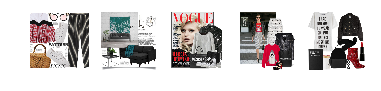

In [11]:
# Find the similar clothings with the query

distance = {}
for i in xrange(len(im_path)):
    # Computing their euclidean distances
    euclidean = scipy.spatial.distance.euclidean(query_COLOR, im_COLOR[i])
    distance[euclidean] = i

# Show the first 5 rank retrieval images
result = []
for key in sorted(distance.iterkeys()):
    result.append(im_path[distance[key]])

print "Retrieval images by Color Histogram:"
for i in range(5):
    print "rank%d: %s" % (i+1, result[i])
plot_results(result[0:5])

Retrieval images by LBP:
rank1: outfit_images/20170821/20170821-226942335.jpg
rank2: outfit_images/20170821/20170821-226956286.jpg
rank3: outfit_images/20170821/20170821-226962207.jpg
rank4: outfit_images/20170821/20170821-226955948.jpg
rank5: outfit_images/20170821/20170821-226962336.jpg


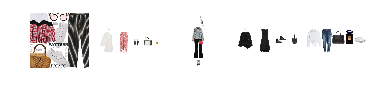

In [12]:
# Find the similar clothings with the query

distance = {}
for i in xrange(len(im_path)):
    # Computing their euclidean distances
    euclidean = scipy.spatial.distance.euclidean(query_LBP, im_LBP[i])
    distance[euclidean] = i

# Show the first 5 rank retrieval images
result = []
for key in sorted(distance.iterkeys()):
    result.append(im_path[distance[key]])

print "Retrieval images by LBP:"
for i in range(5):
    print "rank%d: %s" % (i+1, result[i])
plot_results(result[0:5])

Retrieval images by HOG:
rank1: outfit_images/20170821/20170821-226942335.jpg
rank2: outfit_images/20170821/20170821-226958118.jpg
rank3: outfit_images/20170821/20170821-226961319.jpg
rank4: outfit_images/20170821/20170821-226951487.jpg
rank5: outfit_images/20170821/20170821-226946421.jpg


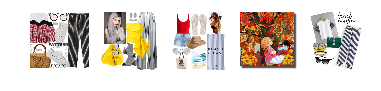

In [13]:
# Find the similar clothings with the query

distance = {}
for i in xrange(len(im_path)):
    # Computing their euclidean distances
    euclidean = scipy.spatial.distance.euclidean(query_HOG, im_HOG[i])
    distance[euclidean] = i

# Show the first 5 rank retrieval images
result = []
for key in sorted(distance.iterkeys()):
    result.append(im_path[distance[key]])

print "Retrieval images by HOG:"
for i in range(5):
    print "rank%d: %s" % (i+1, result[i])
plot_results(result[0:5])

Retrieval images by HOG:
rank1: outfit_images/20170821/20170821-226942335.jpg
rank2: outfit_images/20170821/20170821-226956286.jpg
rank3: outfit_images/20170821/20170821-226955948.jpg
rank4: outfit_images/20170821/20170821-226962336.jpg
rank5: outfit_images/20170821/20170821-226962207.jpg


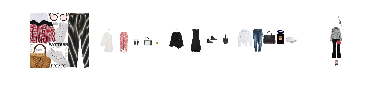

In [14]:
# Find the similar clothings with the query

distance = {}
for i in xrange(len(im_path)):
    # Computing their euclidean distances
    euclidean = scipy.spatial.distance.euclidean(query_feature, im_feature[i])
    distance[euclidean] = i

# Show the first 5 rank retrieval images
result = []
for key in sorted(distance.iterkeys()):
    result.append(im_path[distance[key]])

print "Retrieval images by HOG:"
for i in range(5):
    print "rank%d: %s" % (i+1, result[i])
plot_results(result[0:5])

In [19]:
print len(query_LBP), len(query_HOG)
print len(query_feature)

55590 55590
56102
